<a href="https://colab.research.google.com/github/aarsanjani/meansquares/blob/master/6States_Cluster_Analysis_X3_X5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cluster analysis for 6 states 

*   Demographics

X3_cols = ['% people older than 60', 'Median income', '% African Americans',
       '% Hispanic Americans', '% Male', 'Population density','New cases/1000 people']

*   Hospitalization

X5_cols = ['Hospital beds/1000 people', 'ICUs/1000 people','#days: decreasing ILI cases',
           '% hospital bed utilization','% ICU utilization', 'Ventilator shortage','New cases/1000 people']

## Imports

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

## Load Maryland Data

In [ ]:
maryland_sd_inertia_6states = pd.read_csv('/content/drive/Shared drives/CMPE 295- Master Project/Covid19-data/Maryland_Inertia_Data/Maryland_inertia_clusterlabeled_Oct23.csv',low_memory=False)
maryland_sd_inertia_6states.head()

,State,Postal Code,STFIPS,CTFIPS,CTNAME,Social distancing index,% staying home,Trips/person,% out-of-county trips,% out-of-state trips,Miles/person,Work trips/person,Non-work trips/person,New COVID cases,Population,% change in consumption,date,Transit mode share,% people older than 60,Median income,% African Americans,% Hispanic Americans,% Male,Population density,Employment density,# hot spots/1000 people,Hospital beds/1000 people,ICUs/1000 people,# contact tracing workers/1000 people,New cases/1000 people,Active cases/1000 people,#days: decreasing COVID cases,% hospital bed utilization,Testing capacity,Tests done/1000 people,% ICU utilization,Ventilator shortage,Imported COVID cases,COVID exposure/1000 people,#days: decreasing ILI cases,Unemployment claims/1000 people,Unemployment rate,% working from home,Cumulative inflation rate,COVID death rate,cluster,cluster_label
0,New York,NY,36,36005,Bronx County,65,49,2.24,41.1,4.9,16.4,0.35,1.88,0,1432132,-32.5,2020-01-01,59.89,17,38085,29.3,55.9,47.08,25037,5122,65,2.74,0.22,0.029,0.0,0.0,0,63.5,0.0,0.0,0.0,0,0,0.0,0,2.3,3.8,4.2,0.7,0.0,1,cluster_1
1,New York,NY,36,36005,Bronx County,29,32,3.45,40.1,3.2,22.0,0.69,2.76,0,1432132,-0.9,2020-01-02,59.89,17,38085,29.3,55.9,47.08,25037,5122,65,2.74,0.22,0.029,0.0,0.0,0,63.5,0.0,0.0,0.0,0,0,0.0,0,2.3,3.8,4.2,0.7,0.0,1,cluster_1
2,New York,NY,36,36005,Bronx County,27,32,3.56,39.7,3.5,22.4,0.71,2.85,0,1432132,2.4,2020-01-03,59.89,17,38085,29.3,55.9,47.08,25037,5122,65,2.74,0.22,0.029,0.0,0.0,0,63.5,0.0,0.0,0.0,0,0,0.0,0,2.3,3.8,4.2,0.7,0.0,1,cluster_1
3,New York,NY,36,36005,Bronx County,49,41,2.98,39.4,4.2,19.9,0.42,2.56,0,1432132,-8.1,2020-01-04,59.89,17,38085,29.3,55.9,47.08,25037,5122,65,2.74,0.22,0.029,0.0,0.0,0,63.5,0.0,0.0,0.0,0,0,0.0,0,2.3,3.8,4.2,0.7,0.0,1,cluster_1
4,New York,NY,36,36005,Bronx County,60,48,2.53,39.4,4.0,19.7,0.36,2.17,0,1432132,-22.1,2020-01-05,59.89,17,38085,29.3,55.9,47.08,25037,5122,65,2.74,0.22,0.029,0.0,0.0,0,63.5,0.0,0.0,0.0,0,0,0.0,0,1.2,3.8,4.2,0.7,0.0,1,cluster_1


In [ ]:
### X3 Labels
X3_cols = ['% people older than 60', 'Median income', '% African Americans',
       '% Hispanic Americans', '% Male', 'Population density','New cases/1000 people']

In [ ]:
maryland_sd_inertia_6states_X3 = maryland_sd_inertia_6states[X3_cols]
maryland_sd_inertia_6states_X3.head()

,% people older than 60,Median income,% African Americans,% Hispanic Americans,% Male,Population density,New cases/1000 people
0,17,38085,29.3,55.9,47.08,25037,0.0
1,17,38085,29.3,55.9,47.08,25037,0.0
2,17,38085,29.3,55.9,47.08,25037,0.0
3,17,38085,29.3,55.9,47.08,25037,0.0
4,17,38085,29.3,55.9,47.08,25037,0.0


In [ ]:
### X5 Labels
X5_cols = ['Hospital beds/1000 people', 'ICUs/1000 people','#days: decreasing ILI cases',
           '% hospital bed utilization','% ICU utilization', 'Ventilator shortage','New cases/1000 people']

In [ ]:
maryland_sd_inertia_6states_X5 = maryland_sd_inertia_6states[X5_cols]
maryland_sd_inertia_6states_X5.head()

,Hospital beds/1000 people,ICUs/1000 people,#days: decreasing ILI cases,% hospital bed utilization,% ICU utilization,Ventilator shortage,New cases/1000 people
0,2.74,0.22,0,63.5,0.0,0,0.0
1,2.74,0.22,0,63.5,0.0,0,0.0
2,2.74,0.22,0,63.5,0.0,0,0.0
3,2.74,0.22,0,63.5,0.0,0,0.0
4,2.74,0.22,0,63.5,0.0,0,0.0


## Helper Method

In [ ]:
# Data handling
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Clustering
from sklearn.cluster import KMeans, DBSCAN
from sklearn import preprocessing
from sklearn.metrics import silhouette_score

# Dimensionality reduction
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# Visualization
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3
from matplotlib import animation

%matplotlib inline 


def plot_corr(df):
    corr = df.corr()
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    f, ax = plt.subplots(figsize=(11, 9))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})
    
def plot_tsne(tnse_data, kmeans_labels):
    df_tsne = pd.DataFrame(tsne_data).rename({0: 'x', 1: 'y'}, axis=1)
    df_tsne['z'] = kmeans_labels
    sns.scatterplot(x=df_tsne.x, y=df_tsne.y, hue=df_tsne.z, palette="Set2")
    plt.show()
    
def prepare_pca(n_components, data, kmeans_labels):
    names = ['x', 'y', 'z']
    matrix = PCA(n_components=n_components).fit_transform(data)
    df_matrix = pd.DataFrame(matrix)
    df_matrix.rename({i:names[i] for i in range(n_components)}, axis=1, inplace=True)
    df_matrix['labels'] = kmeans_labels
    
    return df_matrix

def prepare_tsne(n_components, data, kmeans_labels):
    names = ['x', 'y', 'z']
    matrix = TSNE(n_components=n_components).fit_transform(data)
    df_matrix = pd.DataFrame(matrix)
    df_matrix.rename({i:names[i] for i in range(n_components)}, axis=1, inplace=True)
    df_matrix['labels'] = kmeans_labels
    
    return df_matrix

def plot_3d(df, name='labels'):
    iris = px.data.iris()
    fig = px.scatter_3d(df, x='x', y='y', z='z',
                  color=name, opacity=0.5)
    

    fig.update_traces(marker=dict(size=3))
    fig.show()
    
def plot_animation(df, label_column, name):
    def update(num):
        ax.view_init(200, num)

    N=360
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(tsne_3d_df['x'], tsne_3d_df['y'], tsne_3d_df['z'], c=tsne_3d_df[label_column],
               s=6, depthshade=True, cmap='Paired')
    ax.set_zlim(-15, 25)
    ax.set_xlim(-20, 20)
    plt.tight_layout()
    ani = animation.FuncAnimation(fig, update, N, blit=False, interval=50)
    ani.save('{}.gif'.format(name), writer='imagemagick')
    plt.show()

## Fractal Clustering Method

In [ ]:
def fractal_clustering(df, cluster_label,n_clusters):
    df_filtered = df[df['cluster'] == cluster_label]
    training_inputs = df_filtered[X_cols].values

    X = training_inputs
    normalized_vectors = preprocessing.normalize(training_inputs)
    normalized_kmeans = KMeans(n_clusters=n_clusters).fit(normalized_vectors)
    print('Cosine kmeans:{}'.format(silhouette_score(normalized_vectors,
                                          normalized_kmeans.labels_,
                                          metric='cosine')))
    
    pca_df = prepare_pca(2, X, normalized_kmeans.labels_)
    sns.scatterplot(x=pca_df.x, y=pca_df.y, hue=pca_df.labels, 
                palette="Set2")
    
    df_filtered['cluster'] = pca_df.labels.to_list()
  
    return df_filtered

## Rename Method

In [ ]:
def rename_cluster_label(x, prefix = 'cluster_'):
  return prefix+str(x)

## Siloute Score

In [ ]:
training_inputs = maryland_sd_inertia_6states[X3_cols].values
print(training_inputs.shape)

(129545, 7)


In [ ]:
X = training_inputs
print(X.shape)

(129545, 7)


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



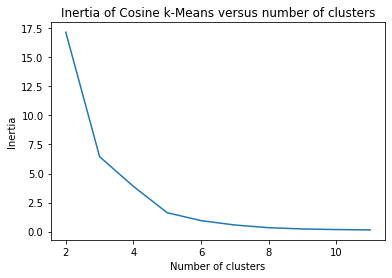

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.metrics import silhouette_score


normalized_vectors = preprocessing.normalize(X)
scores = [KMeans(n_clusters=i+2).fit(normalized_vectors).inertia_  
          for i in range(10)]
sns.lineplot(np.arange(2, 12), scores)
plt.xlabel('Number of clusters')
plt.ylabel("Inertia")
plt.title("Inertia of Cosine k-Means versus number of clusters")
plt.savefig("intertia_cosine_kmeans.jpg", dpi=300)

In [ ]:
normalized_vectors = preprocessing.normalize(X)
normalized_kmeans = KMeans(n_clusters=3).fit(normalized_vectors)

print('Cosine kmeans:{}'.format(silhouette_score(normalized_vectors,
                                          normalized_kmeans.labels_,
                                          metric='cosine')))

Cosine kmeans:0.9975420324605658


## First Cluster X3: Demographics

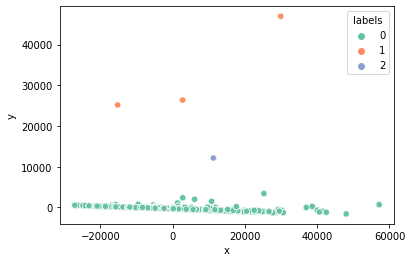

In [ ]:
pca_df = prepare_pca(2, X, normalized_kmeans.labels_)
sns.scatterplot(x=pca_df.x, y=pca_df.y, hue=pca_df.labels, 
                palette="Set2")

In [ ]:
for label in pca_df.labels.unique():
  print("label", label, "  shape",pca_df[pca_df.labels == label].shape)

label 1   shape (861, 3)
label 2   shape (287, 3)
label 0   shape (128397, 3)


In [ ]:
maryland_sd_inertia_6states_X3['cluster'] = pca_df.labels.to_list()
maryland_sd_inertia_6states_X3.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,% people older than 60,Median income,% African Americans,% Hispanic Americans,% Male,Population density,New cases/1000 people,cluster
0,17,38085,29.3,55.9,47.08,25037,0.0,1
1,17,38085,29.3,55.9,47.08,25037,0.0,1
2,17,38085,29.3,55.9,47.08,25037,0.0,1
3,17,38085,29.3,55.9,47.08,25037,0.0,1
4,17,38085,29.3,55.9,47.08,25037,0.0,1


### Fractal Clustering :: Cluster 0

In [ ]:
cluster0 = maryland_sd_inertia_6states_X3[maryland_sd_inertia_6states_X3['cluster'] == 0]
print(cluster0.shape)

(128397, 8)


In [ ]:
X_cols = X3_cols

Cosine kmeans:0.9448842057750658
(128397, 8)
label 1   shape (1158, 8)
label 2   shape (6036, 8)
label 0   shape (121203, 8)


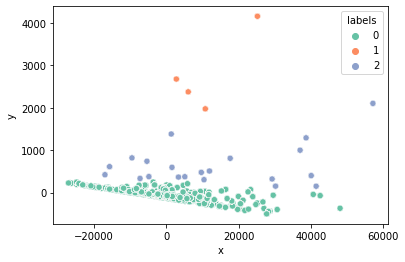

In [ ]:
df_cluster0 = fractal_clustering(cluster0, cluster_label=0,n_clusters=3)
print(df_cluster0.shape)

for label in df_cluster0.cluster.unique():
  print("label", label, "  shape",df_cluster0[df_cluster0.cluster == label].shape)

### Fractal Clustering :: Cluster_0_0

Cosine kmeans:0.6086177200678384


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



(121203, 8)
label 1   shape (10469, 8)
label 2   shape (25849, 8)
label 0   shape (84885, 8)


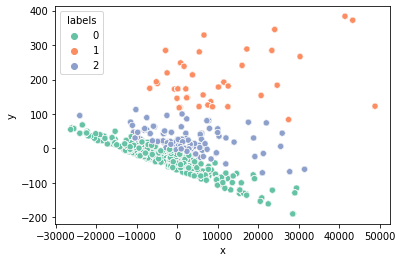

In [ ]:
df_cluster0_0 = fractal_clustering(df_cluster0, cluster_label=0,n_clusters=3)
print(df_cluster0_0.shape)

for label in df_cluster0_0.cluster.unique():
  print("label", label, "  shape",df_cluster0_0[df_cluster0_0.cluster == label].shape)

#### Fractal clustering :: Cluster 0_0_0

Cosine kmeans:0.6446326342229313


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



(84885, 8)
label 0   shape (57389, 8)
label 2   shape (23119, 8)
label 1   shape (4377, 8)


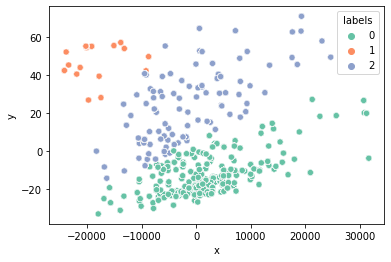

In [ ]:
df_cluster0_0_0 = fractal_clustering(df_cluster0_0, cluster_label=0,n_clusters=3)
print(df_cluster0_0_0.shape)

for label in df_cluster0_0_0.cluster.unique():
  print("label", label, "  shape",df_cluster0_0_0[df_cluster0_0_0.cluster == label].shape)

In [ ]:
df_cluster0_0_0['cluster_label'] = df_cluster0_0_0['cluster'].apply(lambda x: rename_cluster_label(x,'cluster_0_0_0_'))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
#final_data = df_cluster0_0_0.copy()

#### Fractal clustering :: Cluster 0_0_1

Cosine kmeans:0.6820922811646352
(10469, 8)
label 0   shape (3101, 8)
label 2   shape (3644, 8)
label 1   shape (3724, 8)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



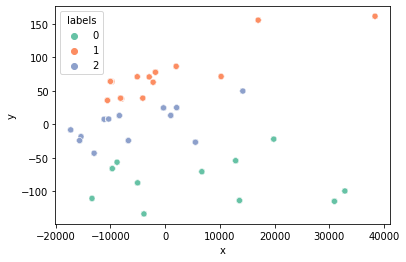

In [ ]:
df_cluster0_0_1 = fractal_clustering(df_cluster0_0, cluster_label=1,n_clusters=3)
print(df_cluster0_0_1.shape)

for label in df_cluster0_0_1.cluster.unique():
  print("label", label, "  shape",df_cluster0_0_1[df_cluster0_0_1.cluster == label].shape)

In [ ]:
df_cluster0_0_1['cluster_label'] = df_cluster0_0_1['cluster'].apply(lambda x: rename_cluster_label(x,'cluster_0_0_1_'))
df_cluster0_0_1.shape

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



(10469, 9)

In [ ]:
#final_data.shape

In [ ]:
#final_data = pd.concat([final_data, df_cluster0_0_1])
#final_data.shape

#### Fractal clustering :: Cluster 0_0_2

Cosine kmeans:0.7215705148102015
(25849, 8)
label 1   shape (6990, 8)
label 0   shape (18317, 8)
label 2   shape (542, 8)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



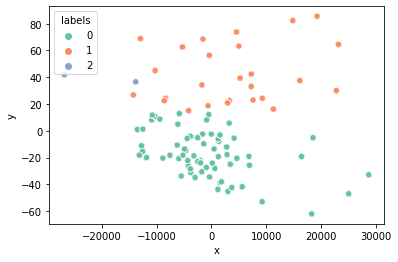

In [ ]:
df_cluster0_0_2 = fractal_clustering(df_cluster0_0, cluster_label=2,n_clusters=3)
print(df_cluster0_0_2.shape)

for label in df_cluster0_0_2.cluster.unique():
  print("label", label, "  shape",df_cluster0_0_2[df_cluster0_0_2.cluster == label].shape)

In [ ]:
df_cluster0_0_2['cluster_label'] = df_cluster0_0_2['cluster'].apply(lambda x: rename_cluster_label(x,'cluster_0_0_2_'))
df_cluster0_0_2.shape

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



(25849, 9)

In [ ]:
#print(final_data.shape)
#final_data = pd.concat([final_data, df_cluster0_0_2])
#final_data.shape

In [ ]:
df_cluster0_0.head()

,% people older than 60,Median income,% African Americans,% Hispanic Americans,% Male,Population density,New cases/1000 people,cluster
1800,19,76716,9.8,20.0,50.1,451,0.2252,1
1801,19,76716,9.8,20.0,50.1,451,0.1274,1
1802,19,76716,9.8,20.0,50.1,451,0.1309,1
1803,19,76716,9.8,20.0,50.1,451,0.1632,1
1804,19,76716,9.8,20.0,50.1,451,0.1684,1


### Fractal clustering :: Cluster_0_1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Cosine kmeans:0.8227861728594084
(1158, 8)
label 0   shape (574, 8)
label 2   shape (287, 8)
label 1   shape (297, 8)


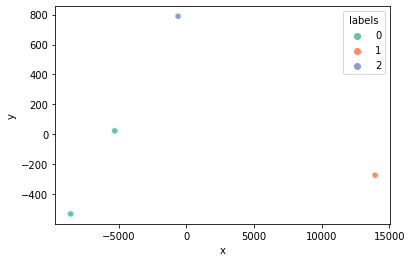

In [ ]:
df_cluster0_1 = fractal_clustering(df_cluster0, cluster_label=1,n_clusters=3)
print(df_cluster0_1.shape)

for label in df_cluster0_1.cluster.unique():
  print("label", label, "  shape",df_cluster0_1[df_cluster0_1.cluster == label].shape)

#### Fractal Clustering :: Cluster_0_1_0

Cosine kmeans:0.9393280607216881
(574, 8)
label 0   shape (258, 8)
label 2   shape (29, 8)
label 1   shape (287, 8)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



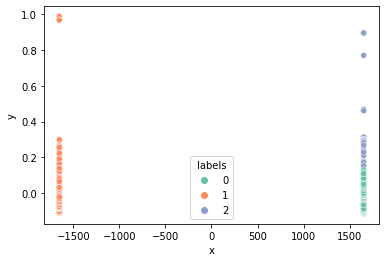

In [ ]:
df_cluster0_1_0 = fractal_clustering(df_cluster0_1, cluster_label=0,n_clusters=3)
print(df_cluster0_1_0.shape)

for label in df_cluster0_1_0.cluster.unique():
  print("label", label, "  shape",df_cluster0_1_0[df_cluster0_1_0.cluster == label].shape)

In [ ]:
df_cluster0_1_0['cluster_label'] = df_cluster0_1_0['cluster'].apply(lambda x: rename_cluster_label(x,'cluster_0_1_0_'))
df_cluster0_1_0.shape

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



(574, 9)

In [ ]:
#print(final_data.shape)
#final_data = pd.concat([final_data, df_cluster0_1_0])
#print(final_data.shape)

#### Fractal Clustering :: Cluster_0_1_1

Cosine kmeans:0.9614367878906332
(297, 8)
label 0   shape (252, 8)
label 1   shape (31, 8)
label 2   shape (14, 8)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



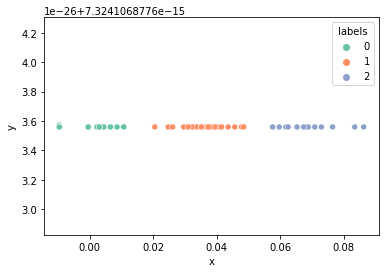

In [ ]:
df_cluster0_1_1 = fractal_clustering(df_cluster0_1, cluster_label=1,n_clusters=3)
print(df_cluster0_1_1.shape)

for label in df_cluster0_1_1.cluster.unique():
  print("label", label, "  shape",df_cluster0_1_1[df_cluster0_1_1.cluster == label].shape)

In [ ]:
df_cluster0_1_1['cluster_label'] = df_cluster0_1_1['cluster'].apply(lambda x: rename_cluster_label(x,'cluster_0_1_1_'))
df_cluster0_1_1.shape

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



(297, 9)

In [ ]:
#print(final_data.shape)
#final_data = pd.concat([final_data, df_cluster0_1_1])
#print(final_data.shape)

#### Fractal Clustering :: Cluster_0_1_2

Cosine kmeans:0.834446807819803
(287, 8)
label 2   shape (20, 8)
label 1   shape (80, 8)
label 0   shape (187, 8)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



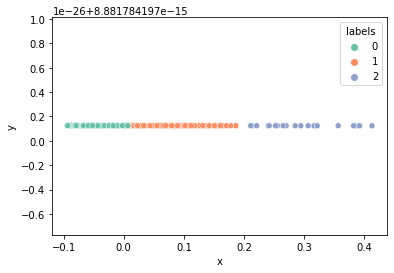

In [ ]:
df_cluster0_1_2 = fractal_clustering(df_cluster0_1, cluster_label=2,n_clusters=3)
print(df_cluster0_1_2.shape)

for label in df_cluster0_1_2.cluster.unique():
  print("label", label, "  shape",df_cluster0_1_2[df_cluster0_1_2.cluster == label].shape)

In [ ]:
df_cluster0_1_2['cluster_label'] = df_cluster0_1_2['cluster'].apply(lambda x: rename_cluster_label(x,'cluster_0_1_2_'))
df_cluster0_1_2.shape

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



(287, 9)

In [ ]:
#print(final_data.shape)
#final_data = pd.concat([final_data, df_cluster0_1_2])
#print(final_data.shape)

### Fractal clustering :: Cluster_0_2

Cosine kmeans:0.8227861728594084
(1158, 8)
label 1   shape (574, 8)
label 2   shape (287, 8)
label 0   shape (297, 8)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



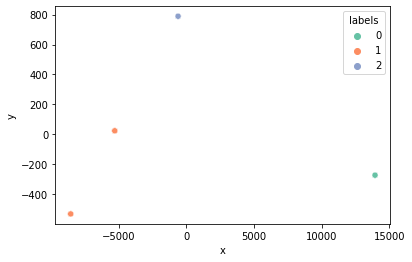

In [ ]:
df_cluster0_2 = fractal_clustering(df_cluster0, cluster_label=1,n_clusters=3)
print(df_cluster0_2.shape)

for label in df_cluster0_2.cluster.unique():
  print("label", label, "  shape",df_cluster0_2[df_cluster0_2.cluster == label].shape)

#### Fractal Clustering :: Cluster_0_2_0

Cosine kmeans:0.9614367878906332
(297, 8)
label 0   shape (252, 8)
label 1   shape (31, 8)
label 2   shape (14, 8)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



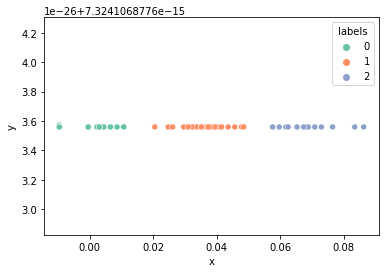

In [ ]:
df_cluster0_2_0 = fractal_clustering(df_cluster0_2, cluster_label=0,n_clusters=3)
print(df_cluster0_2_0.shape)

for label in df_cluster0_2_0.cluster.unique():
  print("label", label, "  shape",df_cluster0_2_0[df_cluster0_2_0.cluster == label].shape)

In [ ]:
df_cluster0_2_0['cluster_label'] = df_cluster0_2_0['cluster'].apply(lambda x: rename_cluster_label(x,'cluster_0_2_0_'))
df_cluster0_2_0.shape

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



(297, 9)

In [ ]:
#print(final_data.shape)
#final_data = pd.concat([final_data, df_cluster0_2_0])
#print(final_data.shape)

#### Fractal Clustering :: Cluster_0_2_1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Cosine kmeans:0.9231347928789639
(574, 8)
label 1   shape (250, 8)
label 2   shape (37, 8)
label 0   shape (287, 8)


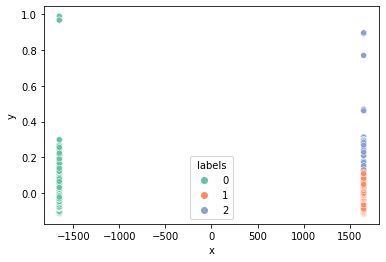

In [ ]:
df_cluster0_2_1 = fractal_clustering(df_cluster0_2, cluster_label=1,n_clusters=3)
print(df_cluster0_2_1.shape)

for label in df_cluster0_2_1.cluster.unique():
  print("label", label, "  shape",df_cluster0_2_1[df_cluster0_2_1.cluster == label].shape)

In [ ]:
df_cluster0_2_1['cluster_label'] = df_cluster0_2_1['cluster'].apply(lambda x: rename_cluster_label(x,'cluster_0_2_1_'))
df_cluster0_2_1.shape

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



(574, 9)

In [ ]:
#print(final_data.shape)
#final_data = pd.concat([final_data, df_cluster0_2_1])
#print(final_data.shape)

#### Fractal Clustering :: Cluster_0_2_2

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Cosine kmeans:0.834446807819803
(287, 8)
label 2   shape (20, 8)
label 1   shape (80, 8)
label 0   shape (187, 8)


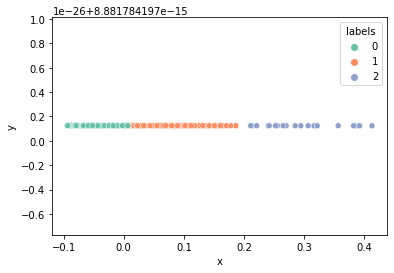

In [ ]:
df_cluster0_2_2 = fractal_clustering(df_cluster0_2, cluster_label=2,n_clusters=3)
print(df_cluster0_2_2.shape)

for label in df_cluster0_2_2.cluster.unique():
  print("label", label, "  shape",df_cluster0_2_2[df_cluster0_2_2.cluster == label].shape)

In [ ]:
df_cluster0_2_2['cluster_label'] = df_cluster0_2_2['cluster'].apply(lambda x: rename_cluster_label(x,'cluster_0_2_2_'))
df_cluster0_2_2.shape

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



(287, 9)

In [ ]:
#print(final_data.shape)
#final_data = pd.concat([final_data, df_cluster0_2_2])
#print(final_data.shape)

## Siloute Score X5

In [ ]:
training_inputs = maryland_sd_inertia_6states[X5_cols].values
print(training_inputs.shape)

(129545, 7)


In [ ]:
X = training_inputs
print(X.shape)

(129545, 7)


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



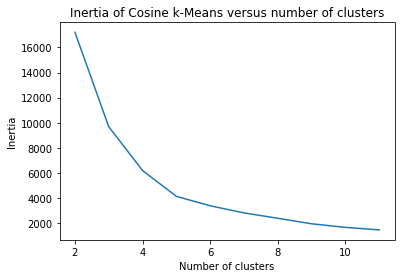

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.metrics import silhouette_score


normalized_vectors = preprocessing.normalize(X)
scores = [KMeans(n_clusters=i+2).fit(normalized_vectors).inertia_  
          for i in range(10)]
sns.lineplot(np.arange(2, 12), scores)
plt.xlabel('Number of clusters')
plt.ylabel("Inertia")
plt.title("Inertia of Cosine k-Means versus number of clusters")
plt.savefig("intertia_cosine_kmeans.jpg", dpi=300)

In [ ]:
normalized_vectors = preprocessing.normalize(X)
normalized_kmeans = KMeans(n_clusters=3).fit(normalized_vectors)

print('Cosine kmeans:{}'.format(silhouette_score(normalized_vectors,
                                          normalized_kmeans.labels_,
                                          metric='cosine')))

Cosine kmeans:0.7237090334169065


## First Cluster X5: Hospital

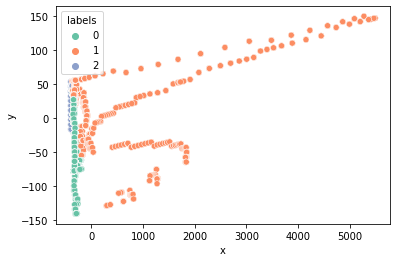

In [ ]:
pca_df = prepare_pca(2, X, normalized_kmeans.labels_)
sns.scatterplot(x=pca_df.x, y=pca_df.y, hue=pca_df.labels, 
                palette="Set2")

In [ ]:
for label in pca_df.labels.unique():
  print("label", label, "  shape",pca_df[pca_df.labels == label].shape)

label 2   shape (40910, 3)
label 1   shape (60841, 3)
label 0   shape (27794, 3)


In [ ]:
maryland_sd_inertia_6states_X5['cluster'] = pca_df.labels.to_list()
maryland_sd_inertia_6states_X5.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Hospital beds/1000 people,ICUs/1000 people,#days: decreasing ILI cases,% hospital bed utilization,% ICU utilization,Ventilator shortage,New cases/1000 people,cluster
0,2.74,0.22,0,63.5,0.0,0,0.0,2
1,2.74,0.22,0,63.5,0.0,0,0.0,2
2,2.74,0.22,0,63.5,0.0,0,0.0,2
3,2.74,0.22,0,63.5,0.0,0,0.0,2
4,2.74,0.22,0,63.5,0.0,0,0.0,2


### Fractal Clustering :: Cluster 0

In [ ]:
cluster0 = maryland_sd_inertia_6states_X5[maryland_sd_inertia_6states_X5['cluster'] == 0]
print(cluster0.shape)

(27794, 8)


In [ ]:
X_cols = X5_cols

Cosine kmeans:0.6365914198539284
(27794, 8)
label 2   shape (9126, 8)
label 0   shape (12584, 8)
label 1   shape (6084, 8)


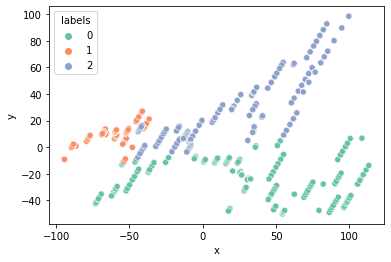

In [ ]:
df_cluster0 = fractal_clustering(cluster0, cluster_label=0,n_clusters=3)
print(df_cluster0.shape)

for label in df_cluster0.cluster.unique():
  print("label", label, "  shape",df_cluster0[df_cluster0.cluster == label].shape)

### Fractal Clustering :: Cluster_0_0

Cosine kmeans:0.6007805332971343
(12584, 8)
label 2   shape (5426, 8)
label 1   shape (5574, 8)
label 0   shape (1584, 8)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



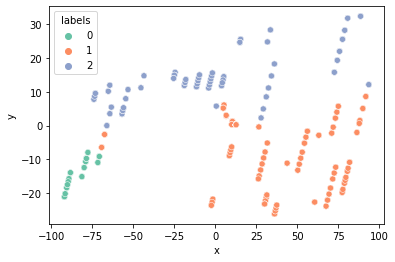

In [ ]:
df_cluster0_0 = fractal_clustering(df_cluster0, cluster_label=0,n_clusters=3)
print(df_cluster0_0.shape)

for label in df_cluster0_0.cluster.unique():
  print("label", label, "  shape",df_cluster0_0[df_cluster0_0.cluster == label].shape)

#### Fractal clustering :: Cluster 0_0_0

Cosine kmeans:0.7861186283496753
(1584, 8)
label 2   shape (396, 8)
label 0   shape (396, 8)
label 1   shape (792, 8)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



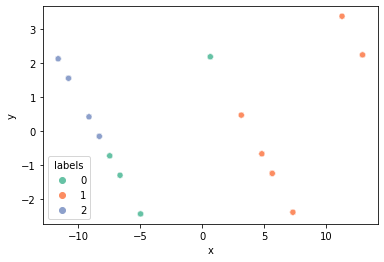

In [ ]:
df_cluster0_0_0 = fractal_clustering(df_cluster0_0, cluster_label=0,n_clusters=3)
print(df_cluster0_0_0.shape)

for label in df_cluster0_0_0.cluster.unique():
  print("label", label, "  shape",df_cluster0_0_0[df_cluster0_0_0.cluster == label].shape)

In [ ]:
df_cluster0_0_0['cluster_label'] = df_cluster0_0_0['cluster'].apply(lambda x: rename_cluster_label(x,'cluster_0_0_0_'))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
#final_data = df_cluster0_0_0.copy()

#### Fractal clustering :: Cluster 0_0_1

Cosine kmeans:0.5557200267225024
(5574, 8)
label 1   shape (1742, 8)
label 0   shape (2127, 8)
label 2   shape (1705, 8)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



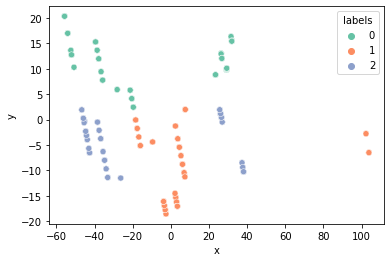

In [ ]:
df_cluster0_0_1 = fractal_clustering(df_cluster0_0, cluster_label=1,n_clusters=3)
print(df_cluster0_0_1.shape)

for label in df_cluster0_0_1.cluster.unique():
  print("label", label, "  shape",df_cluster0_0_1[df_cluster0_0_1.cluster == label].shape)

In [ ]:
df_cluster0_0_1['cluster_label'] = df_cluster0_0_1['cluster'].apply(lambda x: rename_cluster_label(x,'cluster_0_0_1_'))
df_cluster0_0_1.shape

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



(5574, 9)

In [ ]:
#final_data.shape

In [ ]:
#final_data = pd.concat([final_data, df_cluster0_0_1])
#final_data.shape

#### Fractal clustering :: Cluster 0_0_2

Cosine kmeans:0.5413429789758902
(5426, 8)
label 0   shape (2612, 8)
label 1   shape (2382, 8)
label 2   shape (432, 8)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



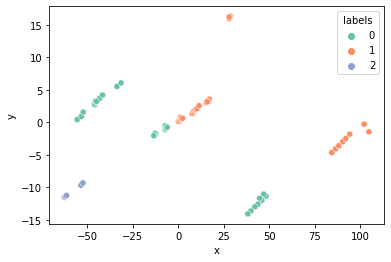

In [ ]:
df_cluster0_0_2 = fractal_clustering(df_cluster0_0, cluster_label=2,n_clusters=3)
print(df_cluster0_0_2.shape)

for label in df_cluster0_0_2.cluster.unique():
  print("label", label, "  shape",df_cluster0_0_2[df_cluster0_0_2.cluster == label].shape)

In [ ]:
df_cluster0_0_2['cluster_label'] = df_cluster0_0_2['cluster'].apply(lambda x: rename_cluster_label(x,'cluster_0_0_2_'))
df_cluster0_0_2.shape

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



(5426, 9)

In [ ]:
#print(final_data.shape)
#final_data = pd.concat([final_data, df_cluster0_0_2])
#final_data.shape

In [ ]:
df_cluster0_0.head()

,Hospital beds/1000 people,ICUs/1000 people,#days: decreasing ILI cases,% hospital bed utilization,% ICU utilization,Ventilator shortage,New cases/1000 people,cluster
214,2.74,0.22,133,64.446575,3.32,105,0.0123,2
215,2.74,0.22,133,64.409177,3.16,101,0.0000,2
216,2.74,0.22,140,64.372913,3.23,97,0.0000,2
217,2.74,0.22,140,64.337901,3.12,93,0.0000,2
218,2.74,0.22,140,64.304249,3.07,89,0.0000,2


### Fractal clustering :: Cluster_0_1

Cosine kmeans:0.676521558444003
(6084, 8)
label 2   shape (1080, 8)
label 1   shape (3780, 8)
label 0   shape (1224, 8)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



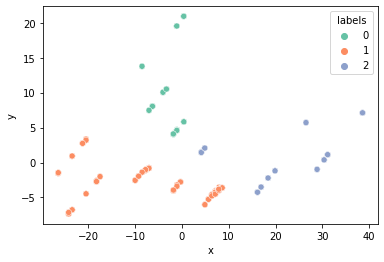

In [ ]:
df_cluster0_1 = fractal_clustering(df_cluster0, cluster_label=1,n_clusters=3)
print(df_cluster0_1.shape)

for label in df_cluster0_1.cluster.unique():
  print("label", label, "  shape",df_cluster0_1[df_cluster0_1.cluster == label].shape)

#### Fractal Clustering :: Cluster_0_1_0

Cosine kmeans:0.8922309877244938
(1224, 8)
label 2   shape (144, 8)
label 0   shape (504, 8)
label 1   shape (576, 8)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



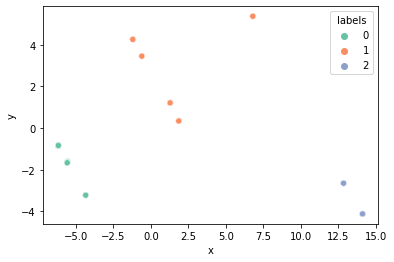

In [ ]:
df_cluster0_1_0 = fractal_clustering(df_cluster0_1, cluster_label=0,n_clusters=3)
print(df_cluster0_1_0.shape)

for label in df_cluster0_1_0.cluster.unique():
  print("label", label, "  shape",df_cluster0_1_0[df_cluster0_1_0.cluster == label].shape)

In [ ]:
df_cluster0_1_0['cluster_label'] = df_cluster0_1_0['cluster'].apply(lambda x: rename_cluster_label(x,'cluster_0_1_0_'))
df_cluster0_1_0.shape

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



(1224, 9)

In [ ]:
#print(final_data.shape)
#final_data = pd.concat([final_data, df_cluster0_1_0])
#print(final_data.shape)

#### Fractal Clustering :: Cluster_0_1_1

Cosine kmeans:0.727551603471302
(3780, 8)
label 0   shape (1386, 8)
label 2   shape (1197, 8)
label 1   shape (1197, 8)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



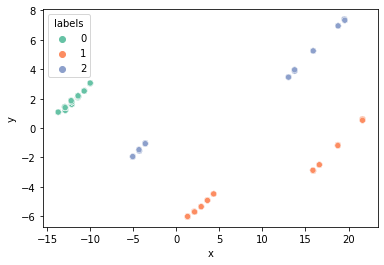

In [ ]:
df_cluster0_1_1 = fractal_clustering(df_cluster0_1, cluster_label=1,n_clusters=3)
print(df_cluster0_1_1.shape)

for label in df_cluster0_1_1.cluster.unique():
  print("label", label, "  shape",df_cluster0_1_1[df_cluster0_1_1.cluster == label].shape)

In [ ]:
df_cluster0_1_1['cluster_label'] = df_cluster0_1_1['cluster'].apply(lambda x: rename_cluster_label(x,'cluster_0_1_1_'))
df_cluster0_1_1.shape

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



(3780, 9)

In [ ]:
#print(final_data.shape)
#final_data = pd.concat([final_data, df_cluster0_1_1])
#print(final_data.shape)

#### Fractal Clustering :: Cluster_0_1_2

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Cosine kmeans:0.8107357451655317
(1080, 8)
label 1   shape (612, 8)
label 0   shape (171, 8)
label 2   shape (297, 8)


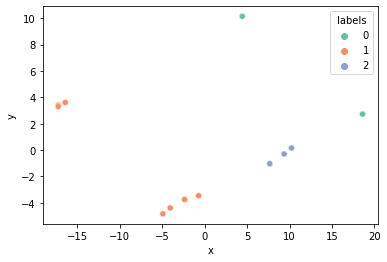

In [ ]:
df_cluster0_1_2 = fractal_clustering(df_cluster0_1, cluster_label=2,n_clusters=3)
print(df_cluster0_1_2.shape)

for label in df_cluster0_1_2.cluster.unique():
  print("label", label, "  shape",df_cluster0_1_2[df_cluster0_1_2.cluster == label].shape)

In [ ]:
df_cluster0_1_2['cluster_label'] = df_cluster0_1_2['cluster'].apply(lambda x: rename_cluster_label(x,'cluster_0_1_2_'))
df_cluster0_1_2.shape

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



(1080, 9)

In [ ]:
#print(final_data.shape)
#final_data = pd.concat([final_data, df_cluster0_1_2])
#print(final_data.shape)

### Fractal clustering :: Cluster_0_2

Cosine kmeans:0.676521558444003
(6084, 8)
label 2   shape (1080, 8)
label 0   shape (3780, 8)
label 1   shape (1224, 8)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



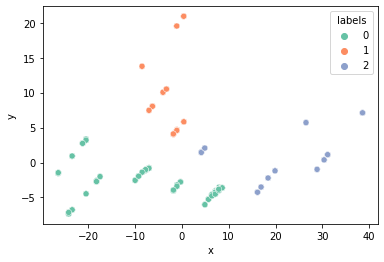

In [ ]:
df_cluster0_2 = fractal_clustering(df_cluster0, cluster_label=1,n_clusters=3)
print(df_cluster0_2.shape)

for label in df_cluster0_2.cluster.unique():
  print("label", label, "  shape",df_cluster0_2[df_cluster0_2.cluster == label].shape)

#### Fractal Clustering :: Cluster_0_2_0

Cosine kmeans:0.727551603471302
(3780, 8)
label 1   shape (1386, 8)
label 2   shape (1197, 8)
label 0   shape (1197, 8)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



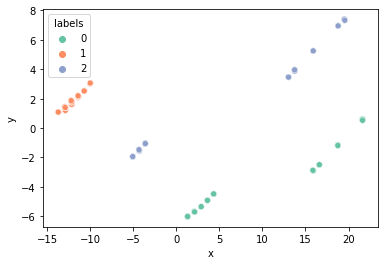

In [ ]:
df_cluster0_2_0 = fractal_clustering(df_cluster0_2, cluster_label=0,n_clusters=3)
print(df_cluster0_2_0.shape)

for label in df_cluster0_2_0.cluster.unique():
  print("label", label, "  shape",df_cluster0_2_0[df_cluster0_2_0.cluster == label].shape)

In [ ]:
df_cluster0_2_0['cluster_label'] = df_cluster0_2_0['cluster'].apply(lambda x: rename_cluster_label(x,'cluster_0_2_0_'))
df_cluster0_2_0.shape

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



(3780, 9)

In [ ]:
#print(final_data.shape)
#final_data = pd.concat([final_data, df_cluster0_2_0])
#print(final_data.shape)

#### Fractal Clustering :: Cluster_0_2_1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Cosine kmeans:0.8922309877244938
(1224, 8)
label 2   shape (144, 8)
label 1   shape (504, 8)
label 0   shape (576, 8)


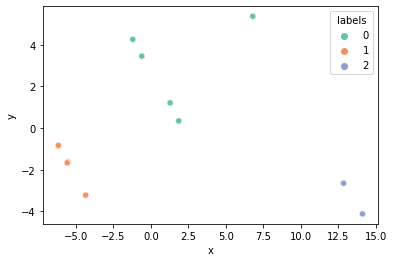

In [ ]:
df_cluster0_2_1 = fractal_clustering(df_cluster0_2, cluster_label=1,n_clusters=3)
print(df_cluster0_2_1.shape)

for label in df_cluster0_2_1.cluster.unique():
  print("label", label, "  shape",df_cluster0_2_1[df_cluster0_2_1.cluster == label].shape)

In [ ]:
df_cluster0_2_1['cluster_label'] = df_cluster0_2_1['cluster'].apply(lambda x: rename_cluster_label(x,'cluster_0_2_1_'))
df_cluster0_2_1.shape

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



(1224, 9)

In [ ]:
#print(final_data.shape)
#final_data = pd.concat([final_data, df_cluster0_2_1])
#print(final_data.shape)

#### Fractal Clustering :: Cluster_0_2_2

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Cosine kmeans:0.8107357451655317
(1080, 8)
label 0   shape (612, 8)
label 2   shape (171, 8)
label 1   shape (297, 8)


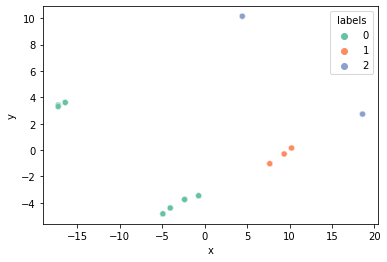

In [ ]:
df_cluster0_2_2 = fractal_clustering(df_cluster0_2, cluster_label=2,n_clusters=3)
print(df_cluster0_2_2.shape)

for label in df_cluster0_2_2.cluster.unique():
  print("label", label, "  shape",df_cluster0_2_2[df_cluster0_2_2.cluster == label].shape)

In [ ]:
df_cluster0_2_2['cluster_label'] = df_cluster0_2_2['cluster'].apply(lambda x: rename_cluster_label(x,'cluster_0_2_2_'))
df_cluster0_2_2.shape

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



(1080, 9)

In [ ]:
#print(final_data.shape)
#final_data = pd.concat([final_data, df_cluster0_2_2])
#print(final_data.shape)

### Fractal Clustering :: Cluster 1

In [ ]:
cluster1 = maryland_sd_inertia_6states_X5[maryland_sd_inertia_6states_X5['cluster'] == 1]
print(cluster1.shape)

(60841, 8)


In [ ]:
X_cols = X5_cols

Cosine kmeans:0.5984234852808737
(60841, 8)
label 2   shape (14082, 8)
label 0   shape (18483, 8)
label 1   shape (28276, 8)


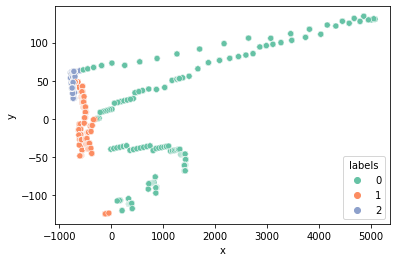

In [ ]:
df_cluster1 = fractal_clustering(cluster1, cluster_label=1,n_clusters=3)
print(df_cluster1.shape)

for label in df_cluster1.cluster.unique():
  print("label", label, "  shape",df_cluster1[df_cluster1.cluster == label].shape)

### Fractal Clustering :: Cluster_1_0

Cosine kmeans:0.7468993651813111
(18483, 8)
label 1   shape (3851, 8)
label 2   shape (11124, 8)
label 0   shape (3508, 8)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



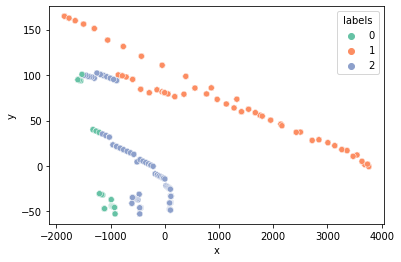

In [102]:
df_cluster1_0 = fractal_clustering(df_cluster1, cluster_label=0,n_clusters=3)
print(df_cluster1_0.shape)

for label in df_cluster1_0.cluster.unique():
  print("label", label, "  shape",df_cluster1_0[df_cluster1_0.cluster == label].shape)

#### Fractal clustering :: Cluster 1_0_0

Cosine kmeans:0.8293790142984419
(3508, 8)
label 2   shape (372, 8)
label 0   shape (1463, 8)
label 1   shape (1673, 8)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



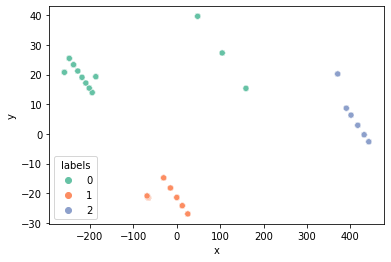

In [103]:
df_cluster1_0_0 = fractal_clustering(df_cluster1_0, cluster_label=0,n_clusters=3)
print(df_cluster1_0_0.shape)

for label in df_cluster1_0_0.cluster.unique():
  print("label", label, "  shape",df_cluster1_0_0[df_cluster1_0_0.cluster == label].shape)

In [104]:
df_cluster1_0_0['cluster_label'] = df_cluster1_0_0['cluster'].apply(lambda x: rename_cluster_label(x,'cluster_1_0_0_'))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [105]:
#final_data = df_cluster1_0_0.copy()

#### Fractal clustering :: Cluster 1_0_1

Cosine kmeans:0.9062057463878744
(3851, 8)
label 1   shape (124, 8)
label 2   shape (244, 8)
label 0   shape (3483, 8)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



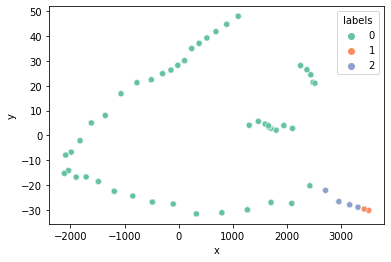

In [106]:
df_cluster1_0_1 = fractal_clustering(df_cluster1_0, cluster_label=1,n_clusters=3)
print(df_cluster1_0_1.shape)

for label in df_cluster1_0_1.cluster.unique():
  print("label", label, "  shape",df_cluster1_0_1[df_cluster1_0_1.cluster == label].shape)

In [107]:
df_cluster1_0_1['cluster_label'] = df_cluster1_0_1['cluster'].apply(lambda x: rename_cluster_label(x,'cluster_1_0_1_'))
df_cluster1_0_1.shape

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



(3851, 9)

In [108]:
#final_data.shape

In [109]:
#final_data = pd.concat([final_data, df_cluster1_0_1])
#final_data.shape

#### Fractal clustering :: Cluster 1_0_2

Cosine kmeans:0.9186271066913314
(11124, 8)
label 2   shape (723, 8)
label 1   shape (1947, 8)
label 0   shape (8454, 8)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



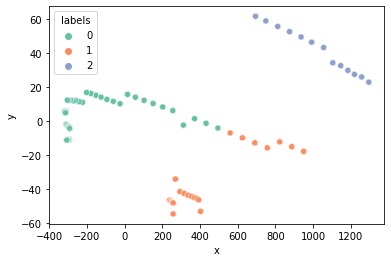

In [110]:
df_cluster1_0_2 = fractal_clustering(df_cluster1_0, cluster_label=2,n_clusters=3)
print(df_cluster1_0_2.shape)

for label in df_cluster1_0_2.cluster.unique():
  print("label", label, "  shape",df_cluster1_0_2[df_cluster1_0_2.cluster == label].shape)

In [111]:
df_cluster1_0_2['cluster_label'] = df_cluster1_0_2['cluster'].apply(lambda x: rename_cluster_label(x,'cluster_1_0_2_'))
df_cluster1_0_2.shape

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



(11124, 9)

In [112]:
#print(final_data.shape)
#final_data = pd.concat([final_data, df_cluster1_0_2])
#final_data.shape

In [113]:
df_cluster1_0.head()

,Hospital beds/1000 people,ICUs/1000 people,#days: decreasing ILI cases,% hospital bed utilization,% ICU utilization,Ventilator shortage,New cases/1000 people,cluster
78,2.74,0.22,0,65.303013,6.39,270,0.0,1
79,2.74,0.22,0,65.881120,8.42,355,0.0,1
80,2.74,0.22,0,66.644313,11.13,469,0.0,1
81,2.74,0.22,0,67.663325,14.78,623,0.0,1
82,2.74,0.22,0,68.976494,19.50,822,0.0,1


### Fractal clustering :: Cluster_1_1

Cosine kmeans:0.7486514335506382
(28276, 8)
label 2   shape (12087, 8)
label 0   shape (9702, 8)
label 1   shape (6487, 8)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



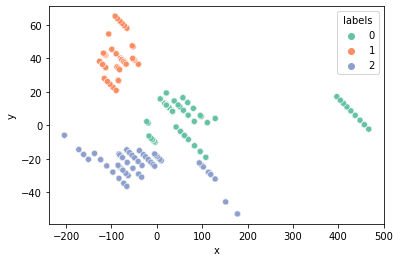

In [114]:
df_cluster1_1 = fractal_clustering(df_cluster1, cluster_label=1,n_clusters=3)
print(df_cluster1_1.shape)

for label in df_cluster1_1.cluster.unique():
  print("label", label, "  shape",df_cluster1_1[df_cluster1_1.cluster == label].shape)

#### Fractal Clustering :: Cluster_1_1_0

Cosine kmeans:0.8177457309416645
(9702, 8)
label 2   shape (2781, 8)
label 1   shape (4755, 8)
label 0   shape (2166, 8)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



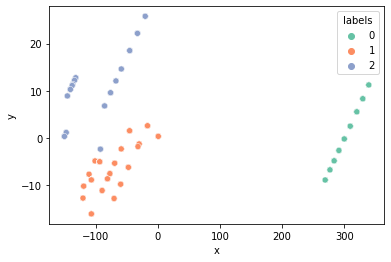

In [115]:
df_cluster1_1_0 = fractal_clustering(df_cluster1_1, cluster_label=0,n_clusters=3)
print(df_cluster1_1_0.shape)

for label in df_cluster1_1_0.cluster.unique():
  print("label", label, "  shape",df_cluster1_1_0[df_cluster1_1_0.cluster == label].shape)

In [116]:
df_cluster1_1_0['cluster_label'] = df_cluster1_1_0['cluster'].apply(lambda x: rename_cluster_label(x,'cluster_1_1_0_'))
df_cluster1_1_0.shape

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



(9702, 9)

In [117]:
#print(final_data.shape)
#final_data = pd.concat([final_data, df_cluster1_1_0])
#print(final_data.shape)

#### Fractal Clustering :: Cluster_1_1_1

Cosine kmeans:0.6831120849049042
(6487, 8)
label 1   shape (2353, 8)
label 0   shape (2356, 8)
label 2   shape (1778, 8)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



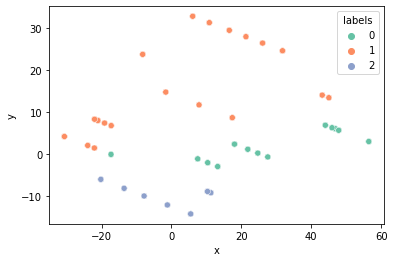

In [118]:
df_cluster1_1_1 = fractal_clustering(df_cluster1_1, cluster_label=1,n_clusters=3)
print(df_cluster1_1_1.shape)

for label in df_cluster1_1_1.cluster.unique():
  print("label", label, "  shape",df_cluster1_1_1[df_cluster1_1_1.cluster == label].shape)

In [119]:
df_cluster1_1_1['cluster_label'] = df_cluster1_1_1['cluster'].apply(lambda x: rename_cluster_label(x,'cluster_1_1_1_'))
df_cluster1_1_1.shape

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



(6487, 9)

In [120]:
#print(final_data.shape)
#final_data = pd.concat([final_data, df_cluster0_1_1])
#print(final_data.shape)

#### Fractal Clustering :: Cluster_1_1_2

Cosine kmeans:0.7238555092664088
(12087, 8)
label 0   shape (5892, 8)
label 1   shape (1369, 8)
label 2   shape (4826, 8)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



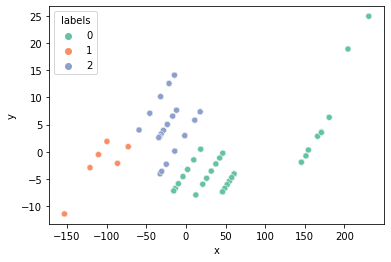

In [121]:
df_cluster1_1_2 = fractal_clustering(df_cluster1_1, cluster_label=2,n_clusters=3)
print(df_cluster1_1_2.shape)

for label in df_cluster1_1_2.cluster.unique():
  print("label", label, "  shape",df_cluster1_1_2[df_cluster1_1_2.cluster == label].shape)

In [122]:
df_cluster1_1_2['cluster_label'] = df_cluster1_1_2['cluster'].apply(lambda x: rename_cluster_label(x,'cluster_1_1_2_'))
df_cluster1_1_2.shape

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



(12087, 9)

In [123]:
#print(final_data.shape)
#final_data = pd.concat([final_data, df_cluster1_1_2])
#print(final_data.shape)